In [1]:
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv,
    global_mean_pool,
    global_add_pool
)
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

import numpy as np
from rdkit.Chem import rdFingerprintGenerator
import deepchem as dc
import random
import optuna

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\predator\anaconda3\envs\dili\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
# Ensure reproducibility with a fixed seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # For deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a global seed for reproducibility
SEED = 42
set_seed(SEED)

In [3]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Preprocessing SMILES Data into Graphs

In [4]:
# Featurization using DeepChem's MolGraphConvFeaturizer
def featurize_smiles(smiles):
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    graph_data = featurizer.featurize([smiles])[0]
    
    # Get DeepChem atom features
    atom_features_deepchem = graph_data.node_features
    
    return atom_features_deepchem

# Function to generate Morgan Fingerprints (ECFP)
def generate_ecfp(smiles):
    # Morgan fingerprint generator
    mfgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096)

    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return None
    return mfgen.GetFingerprintAsNumPy(molecule)

# Function to convert SMILES to PyTorch Geometric Data object using DeepChem featurizer
def smiles_to_graph_featurizer(smiles):
    # Featurization using DeepChem
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)

    # Featurize the SMILES string using DeepChem
    graph_data = featurizer.featurize([smiles])[0]
    return graph_data.node_features, graph_data.edge_features, graph_data.edge_index

# Function to extract atom features
def atom_features(atom, ecfp):
    # Get the atom index for corresponding ECFP value
    atom_idx = atom.GetIdx()
    
    return  [
            atom.GetAtomicNum(),  # Atomic number
            atom.GetDegree(),  # Number of bonds
            atom.GetTotalNumHs(),  # Total number of hydrogens
            atom.GetFormalCharge(),  # Formal charge of the atom
            atom.GetImplicitValence(),  # Implicit valence
            atom.GetNumRadicalElectrons(),  # Number of radical electrons
            int(atom.GetIsAromatic()),  # Is the atom aromatic?
            atom.GetMass(),  # Atomic mass
            atom.GetHybridization().real,  # Hybridization state (SP, SP2, SP3, etc.)
            ecfp[atom_idx],  # Morgan fingerprint (ECFP) for the atom
        ]


# Function to extract bond features
def bond_features(bond):
    bond_type = bond.GetBondTypeAsDouble()            # Bond type as a float
    is_aromatic = bond.GetIsAromatic()                # Aromatic bond
    is_conjugated = bond.GetIsConjugated()            # Conjugated bond
    is_in_ring = bond.IsInRing()                      # Whether the bond is part of a ring
    stereo = bond.GetStereo()                         # Bond stereochemistry
    
    # Convert stereo information to a one-hot encoded format
    stereo_one_hot = [0, 0, 0, 0]  # Stereo options: None, E, Z, Other
    if stereo == Chem.BondStereo.STEREONONE:
        stereo_one_hot[0] = 1
    elif stereo == Chem.BondStereo.STEREOE:
        stereo_one_hot[1] = 1
    elif stereo == Chem.BondStereo.STEREOZ:
        stereo_one_hot[2] = 1
    else:
        stereo_one_hot[3] = 1
    
    # Combine all features into a single tensor
    return [bond_type, float(is_aromatic), float(is_conjugated), float(is_in_ring)] + stereo_one_hot


# Convert SMILES to PyTorch Geometric Data object
def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)

    atom_features_list = []
    edge_index = []
    edge_attr = []

    # DeepChem features
    atom_features_deepchem = featurize_smiles(smiles)

    # Generate Morgan Fingerprint (ECFP)
    ecfp_features = generate_ecfp(smiles)

    # Generate Molecule Graph Convolution features
    mol_graph_node_features, mol_graph_edge_features, mol_graph_edge_index = smiles_to_graph_featurizer(smiles)

    # Nodes (atoms)
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_features(atom, ecfp_features))

    atom_features_list = np.array(atom_features_list)

    # Edges (bonds)
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Append bidirectional edges for undirected graphs
        edge_index.append([i, j])
        edge_index.append([j, i])
        
        # Append bond features for both directions
        edge_attr.append(bond_features(bond))
        edge_attr.append(bond_features(bond))

    # Convert atom features to a tensor
    combined_features = np.concatenate((atom_features_list, atom_features_deepchem, mol_graph_node_features), axis=1)
    x = torch.tensor(combined_features, dtype=torch.float)

    # Convert edge indices and features to tensors, handle empty edge case    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # combine edge features from ECFP and MolGraphConv    
    edge_attr = np.array(edge_attr)
    edge_attr = np.concatenate((edge_attr, mol_graph_edge_features), axis=1)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Label (target)
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)



# Function to load data from CSV and apply SMILES augmentation for training
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path)
    smiles_list = df["Smiles"].values
    labels = df["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0).values

    data_list = []

    # Initialize the SmilesEnumerator for data augmentation
    for smiles, label in zip(smiles_list, labels):
        # For test data, no augmentation, just use canonical SMILES
        graph_data = smiles_to_graph(smiles, label)
        data_list.append(graph_data)

    return data_list

In [5]:
# Load training and testing data
training_data = load_data_from_csv("data_smiles/Training_Group.csv")
testing_data = load_data_from_csv("data_smiles/Testing_Group.csv")

In [6]:
# Create data loaders
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)

In [ ]:
# for i, data in enumerate(test_loader):
#     print(data)

#     if i == 2:
#         break

DataBatch(x=[40, 70], edge_index=[2, 88], edge_attr=[88, 19], y=[1], batch=[40], ptr=[2])
DataBatch(x=[15, 70], edge_index=[2, 30], edge_attr=[30, 19], y=[1], batch=[15], ptr=[2])
DataBatch(x=[27, 70], edge_index=[2, 58], edge_attr=[58, 19], y=[1], batch=[27], ptr=[2])


In [7]:
# Training function with AUC and accuracy tracking
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    for data in data_loader:
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
        y_pred.extend(out[:, 1].detach().cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

In [8]:
# Evaluation function with AUC and accuracy tracking
def test(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Move data to GPU
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
            y_pred.extend(out[:, 1].cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

# Graph Attention Network approach

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers=2, hidden_dim=64, heads=8, concat=True, dropout_prob=0.5, activation='relu'):
        super(GAT, self).__init__()
        
        # Store activation function dynamically
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = F.tanh
        else:
            raise ValueError("Unsupported activation function")

        self.dropout_prob = dropout_prob
        
        # Dynamically define the GAT layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(num_node_features, hidden_dim, heads=heads, concat=concat))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_dim * heads if concat else hidden_dim, hidden_dim, heads=heads, concat=False))
        
        # Final fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply GAT layers dynamically
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.activation(x)
        
        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Apply dropout
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        # Final classification layer
        return F.log_softmax(self.fc(x), dim=1)


In [30]:
def objective(trial):
    # Set the seed for reproducibility in this trial
    set_seed(SEED)
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.6)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 2, 5)  # Number of GAT layers
    heads = trial.suggest_int('heads', 2, 16)  # Number of attention heads
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])  # Activation function
    concat = trial.suggest_categorical('concat', [True, False])  # Whether to concatenate multi-head outputs

    # Initialize the model
    model = GAT(
        num_node_features=70, 
        num_classes=2, 
        num_layers=num_layers, 
        hidden_dim=hidden_dim, 
        heads=heads, 
        concat=concat, 
        dropout_prob=dropout_prob, 
        activation=activation
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    best_auc = 0
    early_stop_counter = 0
    patience = 10
    max_epochs = 300
    epoch_count = 0

    # Metrics storage for plotting
    train_acc_history, train_loss_history, train_auc_history = [], [], []
    test_acc_history, test_loss_history, test_auc_history = [], [], []

    for epoch in range(max_epochs):
        try:
            epoch_count += 1
            train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
            test_loss, test_acc, test_auc = test(model, test_loader, criterion)

            # Store metrics for plotting
            train_acc_history.append(train_acc)
            train_loss_history.append(train_loss)
            train_auc_history.append(train_auc)
            test_acc_history.append(test_acc)
            test_loss_history.append(test_loss)
            test_auc_history.append(test_auc)

            if test_auc > best_auc:
                best_auc = test_auc
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                break
        
        except Exception as e:
            print(f"Error in epoch {epoch}: {e}")
            break

    # Store the number of epochs in the trial's user attributes
    trial.set_user_attr("n_epochs", epoch_count)
    trial.set_user_attr("train_acc_history", train_acc_history)
    trial.set_user_attr("train_loss_history", train_loss_history)
    trial.set_user_attr("train_auc_history", train_auc_history)
    trial.set_user_attr("test_acc_history", test_acc_history)
    trial.set_user_attr("test_loss_history", test_loss_history)
    trial.set_user_attr("test_auc_history", test_auc_history)    

    # Return the best AUC score for this trial
    return best_auc


In [31]:
# Run the Optuna study with the fixed seed
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=50)

[I 2024-10-19 21:41:53,479] A new study created in memory with name: no-name-2b511739-6670-44b3-ab1d-2c51d0422b6e
[I 2024-10-19 21:42:03,920] Trial 0 finished with value: 0.7764009745910199 and parameters: {'hidden_dim': 116, 'dropout_prob': 0.5753571532049581, 'lr': 0.001570297088405539, 'weight_decay': 0.0002481040974867811, 'num_layers': 2, 'heads': 4, 'activation': 'tanh', 'concat': False}. Best is trial 0 with value: 0.7764009745910199.
[I 2024-10-19 21:42:09,860] Trial 1 finished with value: 0.7777932474765052 and parameters: {'hidden_dim': 36, 'dropout_prob': 0.5849549260809972, 'lr': 0.00314288089084011, 'weight_decay': 7.068974950624607e-06, 'num_layers': 2, 'heads': 4, 'activation': 'tanh', 'concat': True}. Best is trial 1 with value: 0.7777932474765052.
[I 2024-10-19 21:42:09,961] Trial 2 finished with value: 0.0 and parameters: {'hidden_dim': 169, 'dropout_prob': 0.16974693032602092, 'lr': 7.52374288453485e-05, 'weight_decay': 2.9204338471814107e-05, 'num_layers': 3, 'heads

Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (838x169 and 2197x2197)


[I 2024-10-19 21:42:10,165] Trial 3 finished with value: 0.0 and parameters: {'hidden_dim': 168, 'dropout_prob': 0.18526206184364577, 'lr': 1.5673095467235405e-05, 'weight_decay': 0.006245139574743076, 'num_layers': 5, 'heads': 14, 'activation': 'relu', 'concat': True}. Best is trial 1 with value: 0.7777932474765052.
[I 2024-10-19 21:42:10,185] Trial 4 finished with value: 0.0 and parameters: {'hidden_dim': 59, 'dropout_prob': 0.34758845505563507, 'lr': 1.2681352169084594e-05, 'weight_decay': 0.004337920697490943, 'num_layers': 3, 'heads': 11, 'activation': 'tanh', 'concat': True}. Best is trial 1 with value: 0.7777932474765052.


Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (793x168 and 2352x2352)
Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (688x59 and 649x649)


[I 2024-10-19 21:42:29,200] Trial 5 finished with value: 0.5153846153846153 and parameters: {'hidden_dim': 250, 'dropout_prob': 0.48756641168055725, 'lr': 0.006584106160121612, 'weight_decay': 0.003795853142670641, 'num_layers': 4, 'heads': 15, 'activation': 'tanh', 'concat': False}. Best is trial 1 with value: 0.7777932474765052.
[I 2024-10-19 21:42:38,741] Trial 6 finished with value: 0.7658197006613296 and parameters: {'hidden_dim': 119, 'dropout_prob': 0.23567451588694796, 'lr': 0.003063462210622081, 'weight_decay': 2.67308831078167e-05, 'num_layers': 3, 'heads': 10, 'activation': 'tanh', 'concat': False}. Best is trial 1 with value: 0.7777932474765052.
[I 2024-10-19 21:42:38,927] Trial 7 finished with value: 0.0 and parameters: {'hidden_dim': 205, 'dropout_prob': 0.1993578407670862, 'lr': 1.0388823104027935e-05, 'weight_decay': 0.0018274508859816032, 'num_layers': 4, 'heads': 12, 'activation': 'relu', 'concat': True}. Best is trial 1 with value: 0.7777932474765052.
[I 2024-10-19 2

Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (993x205 and 2460x2460)
Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (742x226 and 1356x1356)


[I 2024-10-19 21:42:46,097] Trial 9 finished with value: 0.7010093978419769 and parameters: {'hidden_dim': 58, 'dropout_prob': 0.4566223936114975, 'lr': 0.0019158219548093154, 'weight_decay': 0.0001758364027000851, 'num_layers': 5, 'heads': 9, 'activation': 'relu', 'concat': False}. Best is trial 1 with value: 0.7777932474765052.
[I 2024-10-19 21:42:59,665] Trial 10 finished with value: 0.784197702749739 and parameters: {'hidden_dim': 36, 'dropout_prob': 0.566357641688442, 'lr': 0.0005496538318235204, 'weight_decay': 1.1799062523159326e-06, 'num_layers': 2, 'heads': 2, 'activation': 'tanh', 'concat': True}. Best is trial 10 with value: 0.784197702749739.
[I 2024-10-19 21:43:04,181] Trial 11 finished with value: 0.7632439958231814 and parameters: {'hidden_dim': 36, 'dropout_prob': 0.5978921648392923, 'lr': 0.0004451932923910239, 'weight_decay': 1.0919235839151983e-06, 'num_layers': 2, 'heads': 2, 'activation': 'tanh', 'concat': True}. Best is trial 10 with value: 0.784197702749739.
[I 2

Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (1121x134 and 1072x1072)
Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (904x89 and 623x623)


[I 2024-10-19 21:44:19,724] Trial 18 finished with value: 0.7784893839192483 and parameters: {'hidden_dim': 163, 'dropout_prob': 0.11184770575291625, 'lr': 4.0306826045316875e-05, 'weight_decay': 1.2873273974332636e-05, 'num_layers': 2, 'heads': 4, 'activation': 'relu', 'concat': False}. Best is trial 13 with value: 0.7917159763313608.
[I 2024-10-19 21:44:19,760] Trial 19 finished with value: 0.0 and parameters: {'hidden_dim': 76, 'dropout_prob': 0.409139894644061, 'lr': 0.0064279574911470854, 'weight_decay': 7.540238293442766e-05, 'num_layers': 3, 'heads': 5, 'activation': 'tanh', 'concat': True}. Best is trial 13 with value: 0.7917159763313608.


Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (836x76 and 380x380)


[I 2024-10-19 21:44:26,401] Trial 20 finished with value: 0.7811347024016707 and parameters: {'hidden_dim': 114, 'dropout_prob': 0.4986397173266068, 'lr': 0.0009895885705614007, 'weight_decay': 1.0311182672537077e-05, 'num_layers': 2, 'heads': 8, 'activation': 'tanh', 'concat': True}. Best is trial 13 with value: 0.7917159763313608.
[I 2024-10-19 21:44:44,123] Trial 21 finished with value: 0.7798816568047338 and parameters: {'hidden_dim': 54, 'dropout_prob': 0.5341135021231855, 'lr': 0.0003983041661520195, 'weight_decay': 2.1258108517939673e-06, 'num_layers': 2, 'heads': 2, 'activation': 'tanh', 'concat': True}. Best is trial 13 with value: 0.7917159763313608.
[I 2024-10-19 21:44:55,308] Trial 22 finished with value: 0.7781413156978768 and parameters: {'hidden_dim': 63, 'dropout_prob': 0.46050407510127134, 'lr': 0.000728846987109747, 'weight_decay': 2.835345960500377e-06, 'num_layers': 2, 'heads': 3, 'activation': 'tanh', 'concat': True}. Best is trial 13 with value: 0.7917159763313608

Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (940x103 and 618x618)


[I 2024-10-19 21:45:15,921] Trial 25 finished with value: 0.7658893143056039 and parameters: {'hidden_dim': 140, 'dropout_prob': 0.5332923372138203, 'lr': 0.00010569549424860114, 'weight_decay': 3.851807661895114e-06, 'num_layers': 2, 'heads': 5, 'activation': 'tanh', 'concat': True}. Best is trial 13 with value: 0.7917159763313608.
[I 2024-10-19 21:45:37,697] Trial 26 finished with value: 0.7570483814827706 and parameters: {'hidden_dim': 73, 'dropout_prob': 0.3837013765367358, 'lr': 4.4118216043425954e-05, 'weight_decay': 7.490447666425192e-05, 'num_layers': 3, 'heads': 7, 'activation': 'relu', 'concat': False}. Best is trial 13 with value: 0.7917159763313608.
[I 2024-10-19 21:45:47,893] Trial 27 finished with value: 0.7891402714932128 and parameters: {'hidden_dim': 106, 'dropout_prob': 0.2964380533280869, 'lr': 0.0002804473104549427, 'weight_decay': 7.627593865250263e-06, 'num_layers': 2, 'heads': 3, 'activation': 'tanh', 'concat': True}. Best is trial 13 with value: 0.79171597633136

Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (879x103 and 309x309)


[I 2024-10-19 21:46:10,599] Trial 29 finished with value: 0.7899060215802298 and parameters: {'hidden_dim': 126, 'dropout_prob': 0.31685276721731603, 'lr': 0.00014960345954796462, 'weight_decay': 7.985413023308568e-06, 'num_layers': 2, 'heads': 3, 'activation': 'tanh', 'concat': False}. Best is trial 13 with value: 0.7917159763313608.
[I 2024-10-19 21:46:56,978] Trial 30 finished with value: 0.7841280891054647 and parameters: {'hidden_dim': 128, 'dropout_prob': 0.2999849223277925, 'lr': 5.598240297753068e-05, 'weight_decay': 9.053881339361266e-06, 'num_layers': 2, 'heads': 3, 'activation': 'tanh', 'concat': False}. Best is trial 13 with value: 0.7917159763313608.
[I 2024-10-19 21:47:02,501] Trial 31 finished with value: 0.7546815175774453 and parameters: {'hidden_dim': 154, 'dropout_prob': 0.24214049355837636, 'lr': 0.000147719601466939, 'weight_decay': 1.050346507456094e-06, 'num_layers': 2, 'heads': 4, 'activation': 'tanh', 'concat': False}. Best is trial 13 with value: 0.79171597633

Error in epoch 0: mat1 and mat2 shapes cannot be multiplied (824x67 and 670x670)


[I 2024-10-19 21:51:24,991] Trial 47 finished with value: 0.7711103376261748 and parameters: {'hidden_dim': 85, 'dropout_prob': 0.3078954900014182, 'lr': 0.0003123231339436547, 'weight_decay': 1.829755252461875e-05, 'num_layers': 2, 'heads': 6, 'activation': 'tanh', 'concat': False}. Best is trial 42 with value: 0.7919248172641838.
[I 2024-10-19 21:51:58,502] Trial 48 finished with value: 0.781204316045945 and parameters: {'hidden_dim': 132, 'dropout_prob': 0.21453271241850705, 'lr': 8.072158602552265e-05, 'weight_decay': 3.943496510975303e-06, 'num_layers': 2, 'heads': 2, 'activation': 'tanh', 'concat': True}. Best is trial 42 with value: 0.7919248172641838.
[I 2024-10-19 21:52:08,575] Trial 49 finished with value: 0.7676296554124609 and parameters: {'hidden_dim': 107, 'dropout_prob': 0.16713828204438155, 'lr': 0.00048454076241903583, 'weight_decay': 1.8314510836998528e-06, 'num_layers': 2, 'heads': 3, 'activation': 'relu', 'concat': True}. Best is trial 42 with value: 0.7919248172641

In [36]:
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.7919248172641838
  Params: 
    hidden_dim: 117
    dropout_prob: 0.35051308242136886
    lr: 0.00013562833412771182
    weight_decay: 1.882047659305303e-06
    num_layers: 2
    heads: 5
    activation: tanh
    concat: True


In [37]:
print(f"Best trial: {study.best_trial.params}")

Best trial: {'hidden_dim': 117, 'dropout_prob': 0.35051308242136886, 'lr': 0.00013562833412771182, 'weight_decay': 1.882047659305303e-06, 'num_layers': 2, 'heads': 5, 'activation': 'tanh', 'concat': True}


In [38]:
n_epochs = trial.user_attrs['n_epochs']
train_acc_history = trial.user_attrs['train_acc_history']
train_loss_history = trial.user_attrs['train_loss_history']
train_auc_history = trial.user_attrs['train_auc_history']
test_acc_history = trial.user_attrs['test_acc_history']
test_loss_history = trial.user_attrs['test_loss_history']
test_auc_history = trial.user_attrs['test_auc_history']


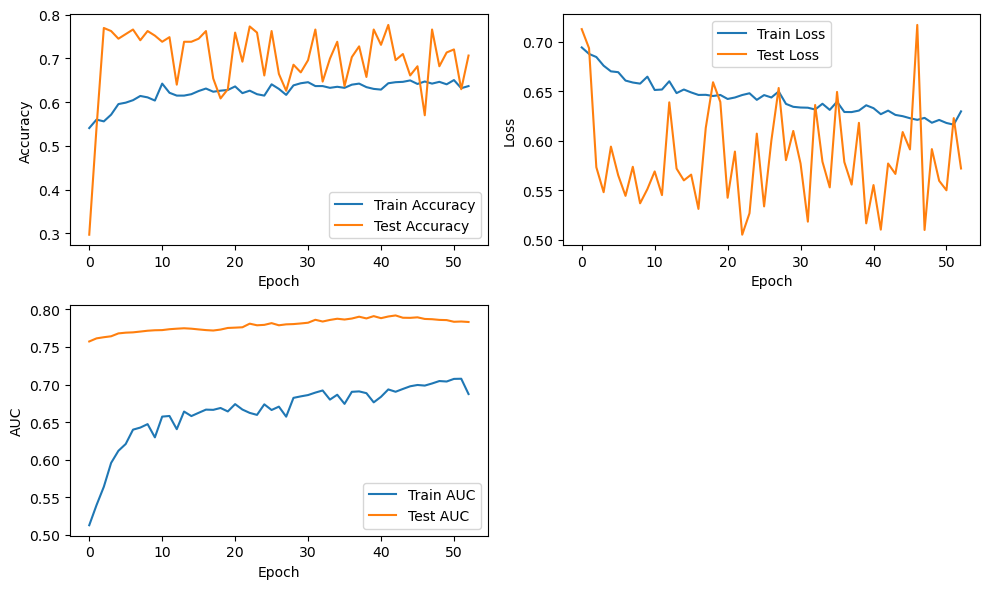

In [39]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()